In [2]:
using ITensors
import KrylovKit 
#using KrylovKit
include("TamaTimeEvoMPS/src/TimeEvoMPS.jl")
using .TimeEvoMPS

In [3]:
using DelimitedFiles
coups = readdlm("lorentz_150.0_1_1.0_T_150_coups.dat");
freqs = readdlm("lorentz_150.0_1_1.0_T_150_freqs.dat");
#system energy gap
eps = 150.

150.0

In [4]:
sys = siteinds("S=1/2",1);
NChain = 30;
env = siteinds("Boson", dim=5, NChain);
NN = NChain + 1;
sysenv = vcat(sys,env);

In [5]:
stateSys = ["Up"];
stateEnv = ["0" for n=1:NChain];
stateSE = vcat(stateSys,stateEnv);
psi0 = productMPS(sysenv,stateSE);

In [6]:
ampo = OpSum()
#system Hamiltonian
ampo += eps,"Sz",1;
#system-env interaction
#!Sx = 0.5 σx
ampo += 2*coups[1],"Sx",1,"Adag",2
ampo += 2*coups[1],"Sx",1,"A",2
#chain local Hamiltonians
for j=2:NChain
   ampo += freqs[j-1],"N",j
end

for j=2:NChain-1
   ampo += coups[j],"A",j,"Adag",j+1
   ampo += coups[j],"Adag",j,"A",j+1
end
H = MPO(ampo,sysenv); 

In [7]:
appo=opPos("Sx",1)
vobs = []
push!(vobs,appo)
push!(vobs,opPos("Sz",1))
push!(vobs,opPos("N",2))
push!(vobs,opPos("N",3))
push!(vobs,opPos("N",4))

5-element Vector{Any}:
 opPos("Sx", 1)
 opPos("Sz", 1)
 opPos("N", 2)
 opPos("N", 3)
 opPos("N", 4)

In [8]:
psi = psi0;
appo = Float64[]
for lookat in vobs
   orthogonalize!(psi,lookat.pos); 
   psidag = dag(prime(psi[lookat.pos],"Site"));
   m=scalar(psidag*op(sysenv,lookat.op,lookat.pos)*psi[lookat.pos])
   push!(appo,m);  
end
appo

5-element Vector{Float64}:
 0.0
 0.5
 0.0
 0.0
 0.0

In [9]:
cbT = LocalMeasurementCallbackTama(vobs,sysenv,0.1)

LocalMeasurementCallback
Operators: opPos[opPos("Sx", 1), opPos("Sz", 1), opPos("N", 2), opPos("N", 3), opPos("N", 4)]
No measurements performed


In [10]:
tdvp!(psi,H,0.01,3,maxdim=20,callback=cbT, progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/tama/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Evolving state... 100%|█████████████████████████████████| Time: 0:56:50
  t:             3.0
  dt step time:  12.197
  Max bond-dim:  20


In [11]:
measurements(cbT)

Dict{String, Vector{Vector{Float64}}} with 5 entries:
  "N_4"  => [[0.000123931], [0.000447593], [0.000614425], [0.000192106], [0.000…
  "Sx_1" => [[-3.79637e-8], [-1.31357e-7], [1.93615e-7], [-2.8503e-7], [3.53802…
  "N_2"  => [[0.0102058], [0.0371778], [0.0753316], [0.126391], [0.194543], [0.…
  "Sz_1" => [[0.484785], [0.442302], [0.378316], [0.29778], [0.203859], [0.1012…
  "N_3"  => [[0.00414986], [0.0142237], [0.0282485], [0.049065], [0.0783939], […

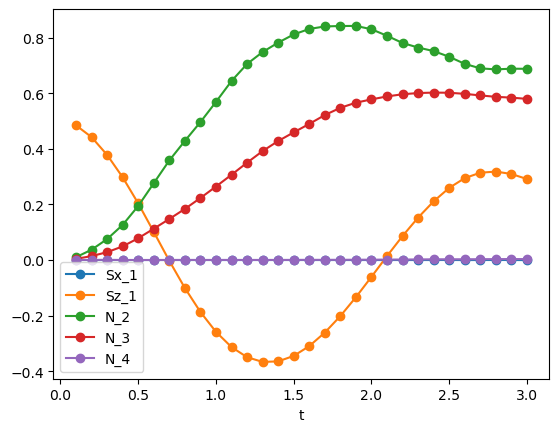

PyObject Text(0.5, 24.0, 't')

In [13]:
using PyPlot
ts = measurement_ts(cbT)
for o in ["Sx_1","Sz_1","N_2","N_3","N_4"]
    S5 = getindex.(measurements(cbT)["$o"],1)
    plot(ts,S5,"-o",label="$o")
end
legend()
xlabel("t")

In [14]:
norm(psi)

1.0